# Investigating the Titanic Survivor Data

This notebook contains source code and analysis of a sample data set for passengers of the Titanic [1]. 

## Project Setup

In [330]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

%matplotlib inline

file_name = 'titanic_data.csv'
titanic_df = pd.read_csv(file_name)
print titanic_df.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


## Questions

Throughout this analysis, I am assuming the single biggest factor in whether someone survived the sinking of the Titanic is whether they were able to get into a life boat. There are undoubtedly other factors, such as injuries sustained during the sinking, or exposure to cold while waiting for rescue, but these would likely have less impact. That is, it's probably safe to assume that an injured person on a life boat was more likely to survive than an uninjured person who went down with the ship. 

Given that, survival rates are less likely to be completely random, and more likely to be correlated with factors that may have influenced the likelihood an individual would be able to get on a lifeboat. I'm particularly interested in what factors could have played a role in increasing or decreasing that likelihood, such as age or wealth, as these are criteria that could indicate discrimination or preferential treatment during the transfer to life boats.

The questions I have chosen to investigate are:
1. How well does this sample represent the total population of Titanic passengers?
2. Was the tradition of 'women and children first' reflected in the percentage of survival rates?
3. Did wealth inequality play a role in the likelihood someone would survive?


## 0. A quick look at the data...

Before we dive into the analysis and try to answer the above questions, let's take a quick look at some of the data to get a better sense for it. The variables I'll be looking at in this analysis in particular are Age, Sex, and 'Wealth', so let's look at those.

### Sex of Passengers

In [331]:
print 'Number of Male and Female Passengers'
print titanic_df['Sex'].value_counts()
print
print 'Percentage of Male and Female Passengers'
print titanic_df['Sex'].value_counts(normalize=True)
print
print 'Counts of Survivors(1) and Non-Survivors(2) by Sex'
pd.pivot_table(titanic_df, values='PassengerId', index=['Sex'], aggfunc='count', columns=['Survived'])

Number of Male and Female Passengers
male      577
female    314
Name: Sex, dtype: int64

Percentage of Male and Female Passengers
male      0.647587
female    0.352413
Name: Sex, dtype: float64

Counts of Survivors(1) and Non-Survivors(2) by Sex


Survived,0,1
Sex,,
female,81,233
male,468,109


About two thirds of passengers were male, however more than two thirds of survivors were female.

### Age


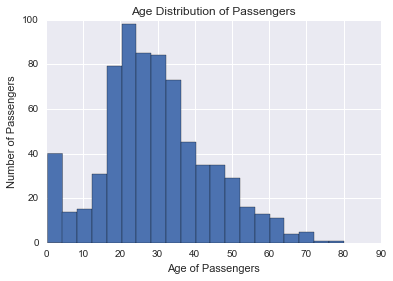

In [332]:
plt.title('Age Distribution of Passengers')
plt.hist(titanic_df['Age'].dropna(), 20)
plt.xlabel('Age of Passengers')
plt.ylabel('Number of Passengers')
plt.show()

We can see from the above visualization that the majority of passengers were between their late-teens and mid-thirties, and the distribution is slighlty positively skewed (which should be expected, given there are a lot more valid ages at which one can be older than a 20-30 year old than there are to be younger than that ;). There is however also a large number of very young children (less than about four years old) among the passengers as well.

NOTE: If we don't do a dropna() on the Age series, we get an error trying to generate the above chart. This is because there are several NaN values in the age column, something we will need to keep in mind when doing further analysis.

### Wealth

We'll explore further what 'wealth' means in a later section, but for now, let's look closer at one of the possible indicator in this data set: Fare ticket prices.

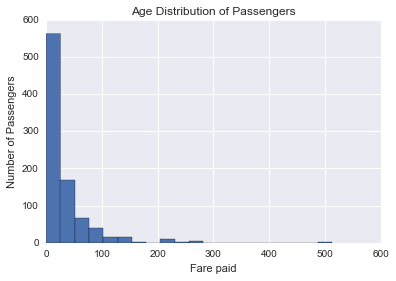

In [333]:
plt.title('Age Distribution of Passengers')
plt.hist(titanic_df['Fare'], 20)
plt.xlabel('Fare paid')
plt.ylabel('Number of Passengers')
plt.show()

This is obviously skewed, with only a few passengers paying more than $200 and over one third in the smallest grouping. This may indicate a lot of 0 values for ticket prices, so let's check that...

In [334]:
titanic_df['Fare'].value_counts().sort_index().head()

0.0000    15
4.0125     1
5.0000     1
6.2375     1
6.4375     1
Name: Fare, dtype: int64

There doesn't appear to be a very large number of 0 values (15), so it's something to keep in mind for further analysis, but isn't necessarily skewing the distribution above. It seems rather that there is a very large number of low ticket fares. Let's zoom in on this a little closer by cutting out all fares > $100.

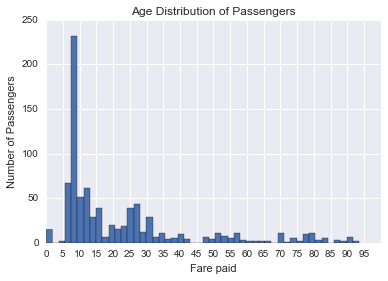

In [335]:
plt.title('Age Distribution of Passengers')
plt.hist(titanic_df['Fare'][titanic_df['Fare']<100], 50)
plt.xticks(np.arange(0, 100, 5))
plt.xlabel('Fare paid')
plt.ylabel('Number of Passengers')
plt.show()

The mode is approximately $7-8, and is by far the most common fare paid by these passengers.



## 1. How well does this sample represent the total population?


The following sections will all investigate factors that may have contributed to whether or not someone was more likely to survive the sinking of the Titanic. In order to gauge how strong any of these findings might be, I want to first look at how well this sample data represents the total population of Titanic passengers.

In order to do this, I'll compare the percentage of people who survived in the data set against the percentage of estimated survivors overall.

### Analysis

#### Actual Survival Rates

While there are no conclusive statistics available for the total number of Titanic passengers or survivors, the British Board of Trade estimates there were 2224 passengers, of whom 710 survived, or 31.92%. [2]  We will assume this is reflective of that actual population.

In [336]:
actual_passenger_count = 2224
actual_survivor_count = 710
actual_survival_rate = float(actual_survivor_count) / actual_passenger_count
print 'Actual Passenger Count: {}, Acutal Survivor Count: {}, Actual Survival Rate: {:4.2f}%'.format(
    actual_passenger_count, actual_survivor_count, actual_survival_rate*100)

Actual Passenger Count: 2224, Acutal Survivor Count: 710, Actual Survival Rate: 31.92%


#### Sample Data Survival Rates

In [337]:
sample_passenger_count = titanic_df['PassengerId'].count()
sample_survivor_count = titanic_df[titanic_df['Survived'] == 1]['PassengerId'].count()
sample_survival_rate = float(sample_survivor_count) / float(sample_passenger_count)
print "Sample Size: {}, Survivor Count: {}, Survival Rate: {:4.2f}%"\
    .format(sample_passenger_count, sample_survivor_count, sample_survival_rate*100)

Sample Size: 891, Survivor Count: 342, Survival Rate: 38.38%


#### Z-test

A survival rate for a sample of size 891 (more than 40% of the total population) should closely reflect the actual survival rates, so a difference of >6% seems significant. To gauge how significant, we can conduct a Z-test, since we know the actual population parameters.

The forumala to calculate the z-statistic is:

* z-statistic = (µX - µ) / ( σ / √ n )

where

* µX = sample mean
* µ = population mean
* σ = population standard deviation
* n = sample sizeon

(Note that we could approximate the population standard deviation by using titanic_df['Survived'].std(), but in this case we can create a mock population with 710 survivors and 2224 passengers, and then get the actual standard deviation).

In [338]:
# create a mock population of 2224 passengers with 710 surivors, and calculate the standard deviation
mock_population = []
for x in range(actual_passenger_count):
    if x < actual_survivor_count:
        mock_population.append(1)
    else:
        mock_population.append(0)

actual_population_std = pd.Series(mock_population).std(ddof=0)
print 'Population Standard Deviation: {:4.2f}'.format(actual_population_std)

z_statistic = (sample_survival_rate - actual_survival_rate) / (actual_population_std / math.sqrt(sample_passenger_count))
print 'Z-Statistic: {:4.2f}'.format(z_statistic)

Population Standard Deviation: 0.47
Z-Statistic: 4.14


A z-statistic > 4 would have a probability of well less than 0.01%, indicating it is highly unlikely a sample this large should have a sample mean so far different than the population mean.

### Conclusion

This sample of data is not representative of the total population of Titanic survivors. The survival rate is 38.38%, while the actual survival rate is only 31.92%. In fact, given this sample size represents ~40% of the total population of Titanic passengers, it would mean the remaining ~60% of passengers would only have a survival rate of 27.61%, almost 30% lower than the sample. Working with a sample from that population would undoubtedly yield different results.

This sample likely suffers from some type of sampling bias. Perhaps it was not selected randomly from all passengers, or perhaps, given a lack of data availability from various pre-incident sources (ticket sales, boarding records, etc), it contains a high ratio of self-reported data provided by survivors post-incident. This would be understandable given survivors would be more likely to provide post-incident data than non-survivors would. ;)

**Therefore, this sample does not represent the total population of Titanic passengers well**, and any conclusions drawn from this sample data should be viewed with some skepticism.

(Note, the above 'actual' numbers may include crew as well as passengers, which may be a significant factor in the difference between the 'actual' and sample survival rates).

## 2. Women and Children first?

When a ship sinks, it is customary to save women and children first [3]. Let's look at whether that happened in the case of the Titanic.

In this case, we'll define children as anyone under the age of 18.

### Data Cleansing

The first issue with the data is that several passengers do not have an age provided. For this question, it's not a concern with female passengers, but we do need to exclude any male passengers that don't have an age.

In [339]:
unaged_males = (titanic_df['Sex'] == 'male') & pd.isnull(titanic_df['Age'])
cleaned_df = titanic_df[~unaged_males]

### Analysis

We'll need to group the data into 2 groups: 'Men' and 'Women or Child'. Then we'll look at the percentage of people who survived in each group (i.e. the 'mean', since 'Survived' is either 1 or 0).

In [340]:
# determine, for each row, if this passenger is an adult male or a 'woman or child'
def is_adult_male(x):
    if(x['Sex'] == 'male' and x['Age'] >= 18):
        return 'Adult Male'
    else:
        return 'Woman or Child'

cleaned_df.loc[:, 'group'] = cleaned_df.apply(is_adult_male, axis=1)

# group by males and women/children, then take the mean
grouped = cleaned_df.groupby('group')['Survived']
results = grouped.agg(['count', 'mean'])
print results

unaged_males_data = titanic_df[unaged_males]
print 'Survival rates for males with no known age {:4.2f}'.format(unaged_males_data['Survived'].mean())

                count      mean
group                          
Adult Male        395  0.177215
Woman or Child    372  0.688172
Survival rates for males with no known age 0.13


I've included the count of each group size as well, just to gauge if there's anything suspicious with the sample sizes. Apparently the data cleansing removed 124 rows, which could impact my findings so I've included the survival rate for these male passengers as well. Since it's lower than the rate for the male group, it's likely the difference in survival rates between the two groups I'm analysis is understated if anything (unless of course, these were all male children - in which case the survival rate for Women and Children would still be > 50%).

### z-test

It's clear here that the survival rate is significantly higher for Women and Children than for adult males; almost 4-to-1 in fact. This seems obviously significant, but let's test it. In this case, we want to compare the proportion of 2 sample populations, so the z-test is:

* z-score = (pX - pY) / √( p * (1-p) * (1/nX + 1/nY) )

Where,
* pX / pY = proportion of survivors in sample X (Adult Males) and Y (Women and Children)
* nX / nY = size of samples X and Y
* p = proportion of all survivors... (survivorsX + survivorsY) / (nX + nY)

In [341]:
def compute_z(seriesX, seriesY):
    nX = len(seriesX)
    yX = len(seriesX[seriesX == 1])
    pX = float(yX)/ nX
    nY = len(seriesY)
    yY = len(seriesY[seriesY == 1])
    pY = float(yY)/ nY
    p = float(yX + yY)/float(nX + nY)    
    z = (pX - pY) / math.sqrt(p * (1-p) * (1./nX + 1./nY))
    return z

adult_males = cleaned_df[cleaned_df['group'] == 'Adult Male']['Survived']
women_and_kids = cleaned_df[cleaned_df['group'] == 'Woman or Child']['Survived']
z_statistic = compute_z(adult_males, women_and_kids)
print 'Z-Score: {:4.2f}'.format(z_statistic)

Z-Score: -14.31


This z-score is obviously large and has a very low probability (p < 0.00001), so the result is statistically significant.

### Conclusion
In the sample data, all females and males under 18 had a 68.81% survival rate as compared to only 17.72% for males over 18 years old. This is very statisically significant and shows that a policy of 'Women and Children first' was likely (but not definitively) practiced.

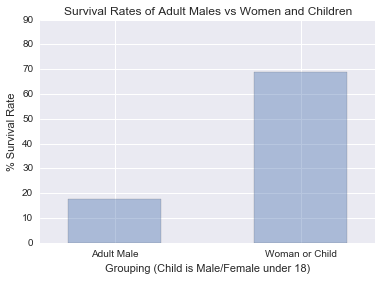

In [342]:
plt.title('Survival Rates of Adult Males vs Women and Children')
plt.bar([0, 1], results['mean'] * 100, align='center', alpha=0.4, width=0.5)
plt.xticks([0, 1], grouped.groups)
plt.xlabel('Grouping (Child is Male/Female under 18)')
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('% Survival Rate')
plt.show()

### One Last Look
It is possible that even young males had a low survival rate, so the above difference could even be understated. That is, perhaps it wasn't 'Women and Children First' so much as just 'Women First'?

To investigate this, let's look at a distribution of survival rates by age for each gender.

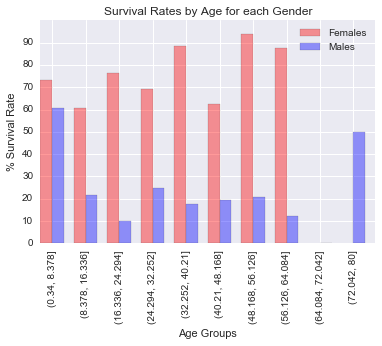

In [343]:
num_buckets = 10 # alter this to see different distributions

# in this case, we need to clean the data to remove unknown ages for both males and females
cleaned = titanic_df[~pd.isnull(titanic_df['Age'])][['Sex', 'Age', 'Survived']]

# place each passenger into a bucket by age range
cleaned['age_bucket'] = pd.cut(cleaned['Age'], num_buckets)
# then for each gender, group by age range and get their survival rates
female_rates_by_age = cleaned[cleaned['Sex'] == 'female'].groupby('age_bucket')['Survived'].mean()
male_rates_by_age = cleaned[cleaned['Sex'] == 'male'].groupby('age_bucket')['Survived'].mean()

# plot as a bar graph. Note that we needed to create our own age buckets in order to show distribution by mean
# since histograms only show a distribution of values, not aggregations of those values. See [4]
bar_width = 0.35
buckets = np.arange(num_buckets)
bucket_labels = cleaned['age_bucket'].unique().categories
plt.bar(buckets, female_rates_by_age.values * 100, width=bar_width, color='red', alpha=0.4)
plt.bar(buckets + bar_width, male_rates_by_age.values * 100, width=bar_width, color='blue', alpha=0.4)

plt.title('Survival Rates by Age for each Gender')
plt.xticks(buckets + bar_width, bucket_labels, rotation='vertical')
plt.xlabel('Age Groups')
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('% Survival Rate')
plt.legend(['Females', 'Males'])

plt.show()

The graph is a bit noisy due to some small sample sizes within each bucket (for example, males over 72), but we can now see that the survival rates for males drops off significantly even well before the age of 18. This indicates that if we redefined the operational construct of 'child' above to have a lower age, we would likely see an even greater difference in survival rates between Men and 'Women and Children'. 

(The reader is welcomed to explore further by adjusting the num_buckets variable above).

## 3. Did Wealth Inequality Play a Role in Survival Rates?

I want to know if 'richer' passengers were given prefential treatment. There's at least 2 data points that may indicate a passenger's 'wealth': Passenger Class and Ticket Fare. Cabin may also be indicative of this, but that data seems too sparse and of poor quality to be useful (not to mention would require looking at where cabins were located to see if that impacted survival rates), so for now I'll ignore that and focus on the other too.

### Data Wrangling

First, we'll drop fares <= 0 as those seem to be erroneous (missing data?). Then let's take a quick look at these two columns to see which one is a better indicator of wealth.

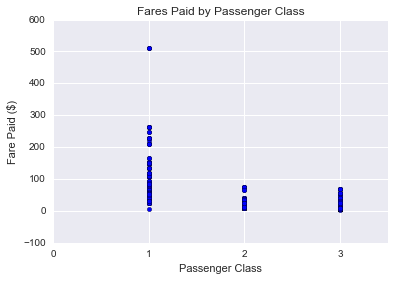

          Pclass      Fare
Pclass  1.000000 -0.561517
Fare   -0.561517  1.000000
          Pclass      Fare
Pclass  1.000000 -0.266767
Fare   -0.266767  1.000000


In [344]:
cleaned = titanic_df[titanic_df['Fare'] > 0]
x = cleaned['Pclass']
y = cleaned['Fare']
plt.scatter(x, y)
plt.xticks(np.arange(0, 4, 1))
plt.xlabel('Passenger Class')
plt.ylabel('Fare Paid ($)')
plt.title('Fares Paid by Passenger Class')
plt.show()

# how correlated are these columns?
print cleaned.loc[:, ['Pclass', 'Fare']].corr()
# what about just for Passenger Classes 2 and 3?
print cleaned.loc[cleaned['Pclass'].isin([2, 3])].loc[:, ['Pclass', 'Fare']].corr()

Surprisingly, there doesn't seem to be much difference between the ticket fairs for each passenger class, except for ticket prices at a very high level. There is indeed some correlation, but the correlation is quite low if we only look at passenger classes 2 and 3.

However, let's cut out fares > $200 to zoom in a little, and look at a boxplot instead. 

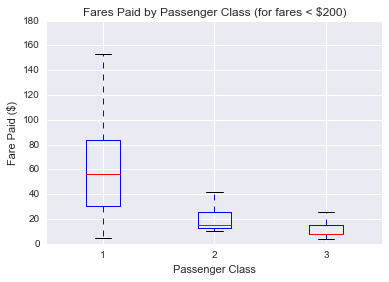

          Pclass      Fare
Pclass  1.000000 -0.672446
Fare   -0.672446  1.000000
          Pclass      Fare
Pclass  1.000000 -0.266767
Fare   -0.266767  1.000000


In [345]:
fares_under_200 = cleaned[cleaned['Fare']<200][['Pclass', 'Fare']]

grouped = fares_under_200.groupby('Pclass')
data_to_plot = []
for name, data in grouped:
     data_to_plot.append(data['Fare'])

plt.boxplot(data_to_plot)
plt.xlabel('Passenger Class')
plt.ylabel('Fare Paid ($)')
plt.title('Fares Paid by Passenger Class (for fares < $200)')
plt.show()

print fares_under_200.corr()
print fares_under_200.loc[fares_under_200['Pclass'].isin([2, 3])].loc[:, ['Pclass', 'Fare']].corr()

There definitely is a difference in fares paid by each class, however, it's still not clear, which would make a better dependent variable to indicate 'wealth'. Let's take a couple more quick looks...

In [346]:
#which wealth indicator correlates more with surviving?
print cleaned.loc[:, ['Pclass', 'Fare', 'Survived']].corr()

#which one shows a greater difference in survival rate trends?
cleaned.loc[:, 'price_bucket'] = pd.qcut(cleaned['Fare'], 10)
print cleaned.groupby('Pclass')['Survived'].agg(['count', 'mean'])
print cleaned.groupby('price_bucket')['Survived'].agg(['count', 'mean'])

            Pclass      Fare  Survived
Pclass    1.000000 -0.561517 -0.351636
Fare     -0.561517  1.000000  0.252453
Survived -0.351636  0.252453  1.000000
        count      mean
Pclass                 
1         211  0.644550
2         178  0.488764
3         487  0.242300
                   count      mean
price_bucket                      
[4.0125, 7.735]       88  0.170455
(7.735, 7.896]       120  0.233333
(7.896, 8.05]         62  0.225806
(8.05, 11.133]        82  0.256098
(11.133, 14.5]        90  0.388889
(14.5, 23]            86  0.488372
(23, 27.721]          86  0.465116
(27.721, 40.125]      87  0.379310
(40.125, 77.958]      88  0.534091
(77.958, 512.329]     87  0.758621


Both show some correlation with survival... so let's just analyze both :)

### Analysis
First, as per the above output, survival rates were higher for the higher classes. How much? Let's do some z-tests

In [347]:
#group the data by Pclass and then get the 'Survived' series for each class
grouped_by_class = cleaned.groupby('Pclass')
class_1 = grouped_by_class.get_group(1)['Survived']
class_2 = grouped_by_class.get_group(2)['Survived']
class_3 = grouped_by_class.get_group(3)['Survived']

#compute the z-statistic for each class's survival rates
print compute_z(class_1, class_2)
print compute_z(class_2, class_3)
print compute_z(class_1, class_3)

3.09490408641
6.09373258192
10.1442768894


All of these z-scores are significant (p < 0.01), particularly when comparing against class 3 (p < 0.0001). It should be noted however that when comparing multiple groups, an ANOVA test should be used to avoid an unacceptably large chance of Type I errors [6]. However, rigorous statistical tests is not in scope for this assignment, so I haven't pursued that since it a) wasn't covered in the course material and b) is already obvious these differences are significant. 

We can also see that survival rates tended to increase as ticket fares increased. To determine how significant this trend is, let's group the passengers by those who survived, and then compare their ticket fares.

In [348]:
def compute_t(seriesX, seriesY):
    nX = len(seriesX)
    muX = seriesX.mean()
    nY = len(seriesY)
    muY = seriesY.mean()
    sum_of_squares_X = sum(seriesX.apply(lambda x: (x- muX)**2))
    sum_of_squares_Y = sum(seriesY.apply(lambda y: (y- muY)**2))
    Sp2 = (sum_of_squares_X + sum_of_squares_Y) / (nX + nY - 2)
    return (muX - muY) / math.sqrt((Sp2 / nX + Sp2 / nY))

grouped_by_survived = cleaned.loc[:, ['Survived', 'Fare']].groupby('Survived')
print grouped_by_survived.mean()
t_stat = compute_t(grouped_by_survived.get_group(1)['Fare'], grouped_by_survived.get_group(0)['Fare'])
print 'T-Statistic for Fare Differences: {:4.2f}'.format(t_stat)

               Fare
Survived           
0         22.696673
1         48.537330
T-Statistic for Fare Differences: 7.71


Again, this is very statistically significant, and clearly shows that people who survived tended to have paid more for their fare aboard the Titanic.



Finally, let's try to visualize survival rates for both Passenger Class and Ticket Fares together...

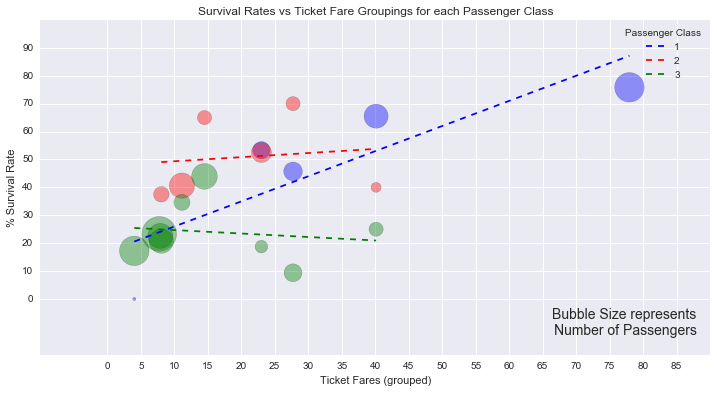

In [349]:
# using a scatter plot is difficult with the default price_bucket labels, as they aren't scalable (strings)
# and some groups have no entries for some buckets. Rather than re-aligning the indexes, it's easier
# to just reformat the labels as the lower bound of each ticket price group, and use that as the x-axis
def get_lower_value(x):
    return float(x.split(',')[0][1:])
cleaned.loc[:, 'price_bucket_lower_limit'] = cleaned['price_bucket'].apply(get_lower_value)

#there is 1 first class passenger who paid $5, which is overstating the trend line for 1st class
# uncomment the line below if you'd like to see the difference this makes (positive trend is still obvious though)
#cleaned = cleaned[~((cleaned['Pclass'] ==1) & (cleaned['Fare'] < 10))]

#group by ticket price and class, then summarize 'Survived' to the survival rate
grouped = cleaned.loc[:, ['price_bucket_lower_limit', 'Pclass', 'Survived']].groupby(['price_bucket_lower_limit', 'Pclass'])
results = grouped.agg(['count', 'mean'])

# plot the results
fig, ax = plt.subplots()
fig.set_size_inches(12,6) #make this plot larger than default
p_classes = [(1, 'blue'), (2, 'red'), (3, 'green')] #colors for each passenger class

for p_class in p_classes:
    # get the full summarized data for each class, then plot it with
    # x, y = ticket fare vs survival rate
    # a different colored series for each pclass
    # bubble sizes that represent the number of passengers in each plot
    data = results.xs(p_class[0], level='Pclass')
    x = data.index
    y = data.loc[:, ('Survived', 'mean')] * 100
    s = data.loc[:, ('Survived', 'count')] * 10
    plt.scatter(x, y, s=s, c=p_class[1], alpha=0.4)  
    
    # add a trend line for each passenger group
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), 'r--', c=p_class[1])

plt.title('Survival Rates vs Ticket Fare Groupings for each Passenger Class')
plt.xticks(np.arange(0, 90, 5))
plt.xlabel('Ticket Fares (grouped)')
plt.yticks(np.arange(0, 100, 10))
plt.ylabel('% Survival Rate')
plt.legend([1, 2, 3], title='Passenger Class')
plt.text(.98, 0.05, "Bubble Size represents\nNumber of Passengers",
        transform=ax.transAxes,
        horizontalalignment='right',
        verticalalignment='bottom',
        size=14)

plt.show()

Here we can see a number of interesting observations, which I'll state generally rather than doing rigorous statistical analysis:

* There are noticeably greater rates of survival for the higher passenger classes
* While the general trend is higher survival rates for higher ticket fares, the correlation isn't overtly strong (as previously noted), and seems to differ by passenger class. Higher ticket fares really only correlate strongly with higher survival rates for 1st class passengers. For the other classes, it seems to have a negligible effect, and perhaps even a negative effect for 3rd class passengers. (NOTE: these trend lines aren't weighted by the size of each data point, so one would need to calculate the survival and fare correlation for each passenger class to determine this for sure. It is interesting none-the-less).
* There are several cases where passengers had higher survival rates despite being both lower-classed and paying less for their tickets. Clearly, there is more going on here than just preferential treatment for wealthier customers. It's possible that passengers in some groups which are well above their trend lines were located in cabins that had closer proximity to the life boats, for example.

### Conclusion

There is a positive correlation between survival rates between both passenger classes and ticket fares, and the difference in survival rates between passenger classes in particular is very statistically significant (p < 0.01, or even p < 0.0001 for 3rd class passengers).

This correlation indicates that wealthier passengers could have been given priority for seating on life boats, however, it certainly does not prove it and should not be considered definitive causation. It is possible that the cabins of wealthier passengers tended to simply be located closer to the life boats and they reached them first. It is also possible that wealtheir passengers had more opportunity to take swimming lessons, and were thus better prepared to survive a shipwreck :)

# Conclusion

We began by asking the following questions

1. How well does this sample represent the total population of Titanic passengers?
2. Was the tradition of 'women and children' first reflected in the percentage of survival rates?
3. Did wealth inequality play a role in the likelihood someone would survive?

And the above analysis has shown the following:

1. No, this sample does not represent the total population of the Titanic very well, if we assume the statistics provided in [1] are accurate. The difference in survival rates is 6.46%, with a Z-score of 4.14 (p < 0.01). Given the size of the sample relative to the total population of Titanic passengers (841 vs 2204), there appears to be some sampling bias in this data set (perhaps exclusion of crew).

2. Yes, women and children were more far more likely to survive than were adult males. 68.82% women and children survived, while only 17.72% of adult males survived, and the difference in these proportions is highly statistically significant (z-score -14.41, p < 0.00001). The survival rates for males in particular seems to drop off substantionally past the age of about 8-10, which was not the case for women.

3. Yes, wealth inequality did play a role in the likelihood someone would survive, as indicated by the correlation of higher survival rates for ticket prices and passenger classes. Interestingly, the ticket fares paid among lower passengers did not seem to have much impact, but was greater among first class passengers.

Overall, it appears an individual's chances of surviving the Titanic were not just random chance, but could be influenced by such factors as Age, Sex, and Wealth (as indicated by Passenger Class and Ticket Fares).


### Further Research

In keeping with the theme of potential discrimination or preferential treatment, it would be interesting to also look at other possible factors in this data set. For example, the data set shows three different ports of embarkation; Cherbourg (France), Queenstown (Ireland), and Southampton (England). One could assume these may be a proxy for the nationality of passengers and investigate if there's any correlation between these and survival rates to determine if nationality was correlated with survival. (see addendum below for a quick example)

Stepping into other areas, it would also be of interest to investigate if traveling with companions, and which types of companions, increased or decreased someone's likelihood of survival. (Again, see addendum... it appears those traveling in groups of 2-4 had higher rates of survival than those traveling alone or in larger groups). Going even further, if one were to research the layout of cabins and lifeboats on the Titanic from additional sources, it may be possible to determine if proximity to a lifeboat location was correlated with survival.

# Addendum

Some cursory looks at the a few of the suggestions in 'further research' above.


In [351]:
# survival rates by port of embarkation
print titanic_df.groupby('Embarked')['Survived'].mean()
print 
# sum the total number of known relationships each person was traveling with
# then 
titanic_df.loc[:, 'all_companions'] = titanic_df['SibSp'] + titanic_df['Parch']
print titanic_df.groupby('all_companions')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

all_companions
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64



# Appendix - Sources

1. Titanic Survivor Sample Data - https://www.udacity.com/api/nodes/5420148578/supplemental_media/titanic-datacsv/download?_ga=1.135145714.214683858.1464750905

2. Estimations for Total Survivor Ratios - https://en.wikipedia.org/wiki/RMS_Titanic#Survivors_and_victims

3. Women and Children First - https://en.wikipedia.org/wiki/Women_and_children_first

4. Plotting aggregate data in histograms - http://stackoverflow.com/questions/27157522/pandas-plot-histogram-data-frame-index

5. Calculating p values for t scores - http://www.socscistatistics.com/pvalues/tdistribution.aspx

6. Anova tests - https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-2.php
